In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist # functions for loading and plotting MNIST
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# loads dataset

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
# Encoder and decoder classes

class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [4]:
# Class for autoencoder

class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0) # calculates rho from encoder activations
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):        
        dkl = - rho * torch.log(self.data_rho) - (1-rho)*torch.log(1-self.data_rho) # calculates KL divergence
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [26]:
# Making AEs with 16, 64 and 256 neurons in latent layer

models = {"16": Net(16), "64": Net(64), "256": Net(256)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [99]:
# Train function

def train(epoch, models, log=None, add_noise=False, half_image=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            inputs = data.clone().detach()
            if add_noise:
                inputs = noise_batch(inputs)
            if half_image:
                inputs = half_batch(inputs)
            output = model(inputs)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [91]:
avg_lambda = lambda l: "loss: {:.4f}".format(l)
rho_lambda = lambda p: "rho_loss: {:.4f}".format(p)
line = lambda i, l, p: "{}: ".format(i) + avg_lambda(l) + "\t" + rho_lambda(p)
  
# Test function    
    
def test(models, loader, log=None, add_noise=False, half_image=False):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            inputs = data.clone().detach()
            if add_noise:
                inputs = noise_batch(inputs)
            if half_image:
                inputs = half_batch(inputs)
            output = {k: m(inputs) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction="sum").item()
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = "\n".join([line(k, test_loss[k], rho_loss[k]) for k in models]) + "\n"
    report = "Test set:\n" + lines        
    print(report)

In [27]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.029873 64: 1.023488 256: 1.056134
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.909954 64: 0.719857 256: 0.358256
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.858252 64: 0.447566 256: 0.270724
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.748796 64: 0.352775 256: 0.223446
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.631818 64: 0.330086 256: 0.209781
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.532608 64: 0.301343 256: 0.192799
Test set:
16: loss: 0.5306	rho_loss: 0.0062
64: loss: 0.2910	rho_loss: 0.0059
256: loss: 0.1813	rho_loss: 0.0050

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.526194 64: 0.282654 256: 0.175252
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.462374 64: 0.268498 256: 0.168868
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.425766 64: 0.256113 256: 0.157694
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.400720 64: 0.231686 256: 0.141270
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.376545 64: 0.225256 256: 0.

Train Epoch: 14 [40000/50000 (80%)]	Losses 16: 0.160520 64: 0.086152 256: 0.033154
Train Epoch: 14 [50000/50000 (100%)]	Losses 16: 0.155201 64: 0.081246 256: 0.034371
Test set:
16: loss: 0.1632	rho_loss: 0.0043
64: loss: 0.0867	rho_loss: 0.0042
256: loss: 0.0365	rho_loss: 0.0041

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.139922 64: 0.071349 256: 0.028083
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.156382 64: 0.077149 256: 0.030879
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.154075 64: 0.085740 256: 0.036334
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.161972 64: 0.081389 256: 0.033985
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.164256 64: 0.085476 256: 0.035217
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.164290 64: 0.086315 256: 0.035913
Test set:
16: loss: 0.1605	rho_loss: 0.0043
64: loss: 0.0844	rho_loss: 0.0042
256: loss: 0.0351	rho_loss: 0.0041

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.161355 64: 0.083488 256: 0.031861
Train Epoch: 16 [10000/50000 (20%

Train Epoch: 28 [0/50000 (0%)]	Losses 16: 0.125768 64: 0.058379 256: 0.020632
Train Epoch: 28 [10000/50000 (20%)]	Losses 16: 0.141550 64: 0.066116 256: 0.024850
Train Epoch: 28 [20000/50000 (40%)]	Losses 16: 0.149059 64: 0.066059 256: 0.024986
Train Epoch: 28 [30000/50000 (60%)]	Losses 16: 0.146408 64: 0.067776 256: 0.025080
Train Epoch: 28 [40000/50000 (80%)]	Losses 16: 0.130912 64: 0.064812 256: 0.024481
Train Epoch: 28 [50000/50000 (100%)]	Losses 16: 0.141668 64: 0.068269 256: 0.024885
Test set:
16: loss: 0.1412	rho_loss: 0.0042
64: loss: 0.0663	rho_loss: 0.0042
256: loss: 0.0252	rho_loss: 0.0041

Train Epoch: 29 [0/50000 (0%)]	Losses 16: 0.133451 64: 0.060326 256: 0.021744
Train Epoch: 29 [10000/50000 (20%)]	Losses 16: 0.129537 64: 0.061250 256: 0.022667
Train Epoch: 29 [20000/50000 (40%)]	Losses 16: 0.140426 64: 0.061839 256: 0.023201
Train Epoch: 29 [30000/50000 (60%)]	Losses 16: 0.147390 64: 0.068670 256: 0.023755
Train Epoch: 29 [40000/50000 (80%)]	Losses 16: 0.139334 64: 0.063

Train Epoch: 41 [30000/50000 (60%)]	Losses 16: 0.134071 64: 0.058770 256: 0.020806
Train Epoch: 41 [40000/50000 (80%)]	Losses 16: 0.133090 64: 0.056136 256: 0.019487
Train Epoch: 41 [50000/50000 (100%)]	Losses 16: 0.144228 64: 0.062136 256: 0.021737
Test set:
16: loss: 0.1319	rho_loss: 0.0042
64: loss: 0.0582	rho_loss: 0.0042
256: loss: 0.0210	rho_loss: 0.0041

Train Epoch: 42 [0/50000 (0%)]	Losses 16: 0.133333 64: 0.064007 256: 0.022288
Train Epoch: 42 [10000/50000 (20%)]	Losses 16: 0.117905 64: 0.053932 256: 0.018325
Train Epoch: 42 [20000/50000 (40%)]	Losses 16: 0.136282 64: 0.057517 256: 0.019855
Train Epoch: 42 [30000/50000 (60%)]	Losses 16: 0.140770 64: 0.062971 256: 0.021105
Train Epoch: 42 [40000/50000 (80%)]	Losses 16: 0.137055 64: 0.062806 256: 0.021521
Train Epoch: 42 [50000/50000 (100%)]	Losses 16: 0.137554 64: 0.057871 256: 0.019139
Test set:
16: loss: 0.1312	rho_loss: 0.0042
64: loss: 0.0581	rho_loss: 0.0042
256: loss: 0.0208	rho_loss: 0.0041

Train Epoch: 43 [0/50000 (0%

Plots of loss on validation set show smooth decrease of reconstruction and rho loss (for 256 latent dimensions and 50 epochs training). The model did not overfit on train data.

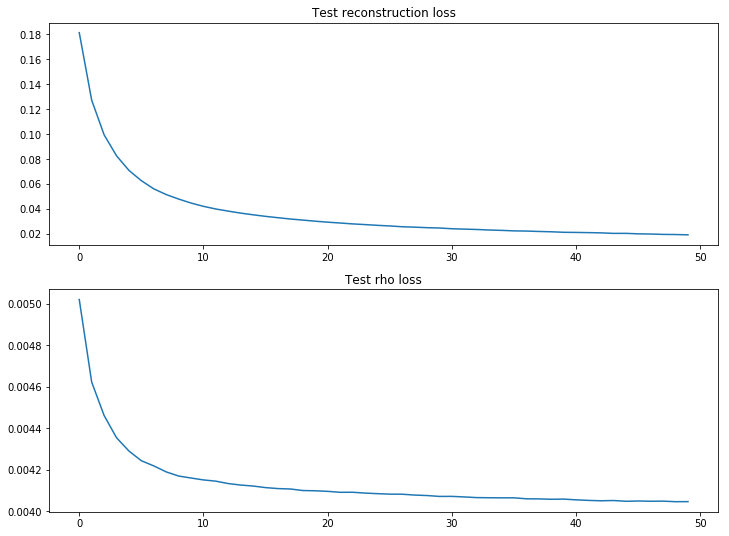

In [47]:
fig, ax = plt.subplots(2, figsize=(12,9))
ax[0].plot(np.array(test_log["256"])[:,0])
ax[0].set_title("Test reconstruction loss")
ax[1].plot(np.array(test_log["256"])[:,1])
ax[1].set_title("Test rho loss")
plt.show()

Checking the model outputs from different inputs. 

1. Reconstruction of batch of images from test set;
2. Decoding identity matrix, where only one latent neuron is active;
3. Counting number of hidden neurons with activations > 0.5. The model with 256 neurons has only few of them active at same time. Setting activations of those with < 0.5 to 0 to check what decoder can generate from those few.

In [53]:
data, _ = next(iter(test_loader))

#(1.)
output = models["256"](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

#(2.)
decoded = models["256"].decode(torch.eye(256))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models["256"].E(data.view(-1, 28*28))
    
    #(3.)
    print("Number of neurons with activation > 0.5:\n", (encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.    
    decoded_f = models["256"].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

Number of neurons with activation > 0.5:
 tensor([ 4, 10,  1,  3,  5,  2,  7,  4,  9,  5,  4,  2,  2,  4,  4,  8,  3,  6,
        12,  3,  3,  2,  4,  5,  2,  9,  3,  3,  4,  4,  4,  5,  4,  7,  5,  6,
         4,  2,  2,  2,  1,  1,  3,  5,  3,  1,  7,  3,  3,  7])


Plotting original and reconstructed images. The model makes a fairly decent reconstruction of input.

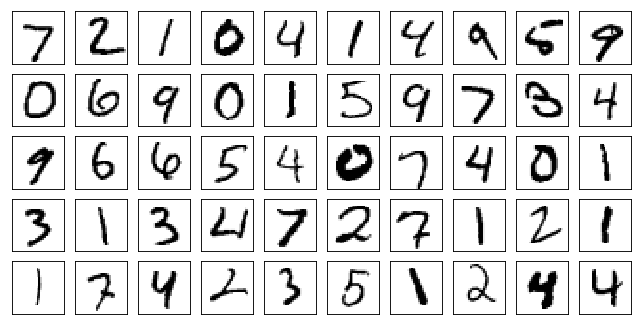

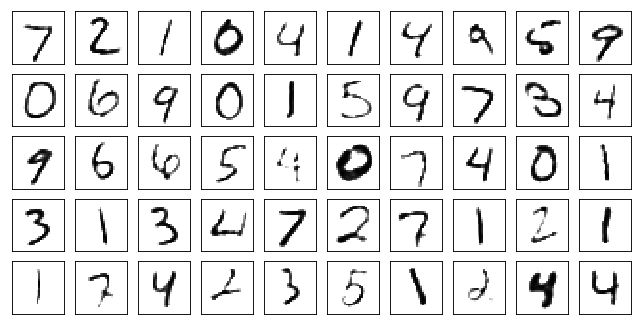

In [54]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))

Plot of images reconstructed from latent space with zeroed "inactive" neurons (activation < 0.5). Many of the numbers a recognizable, so sparse latent representation did learn useful features. The deactivated neurons mostly were responsible for background noise.

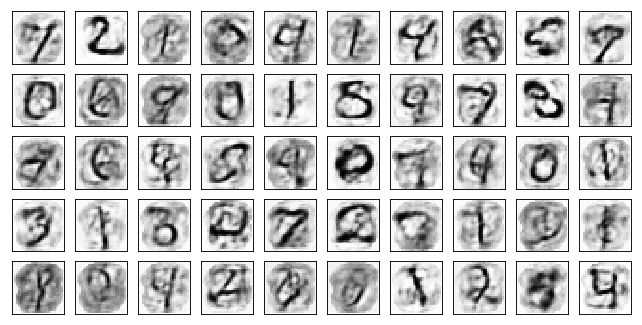

In [56]:
plot_mnist(f_to_plot, (5, 10))

Plot of decoded images from identity matrix. The images look very blurry, but even with only one neuron active in latent layer there can be seen some structure.

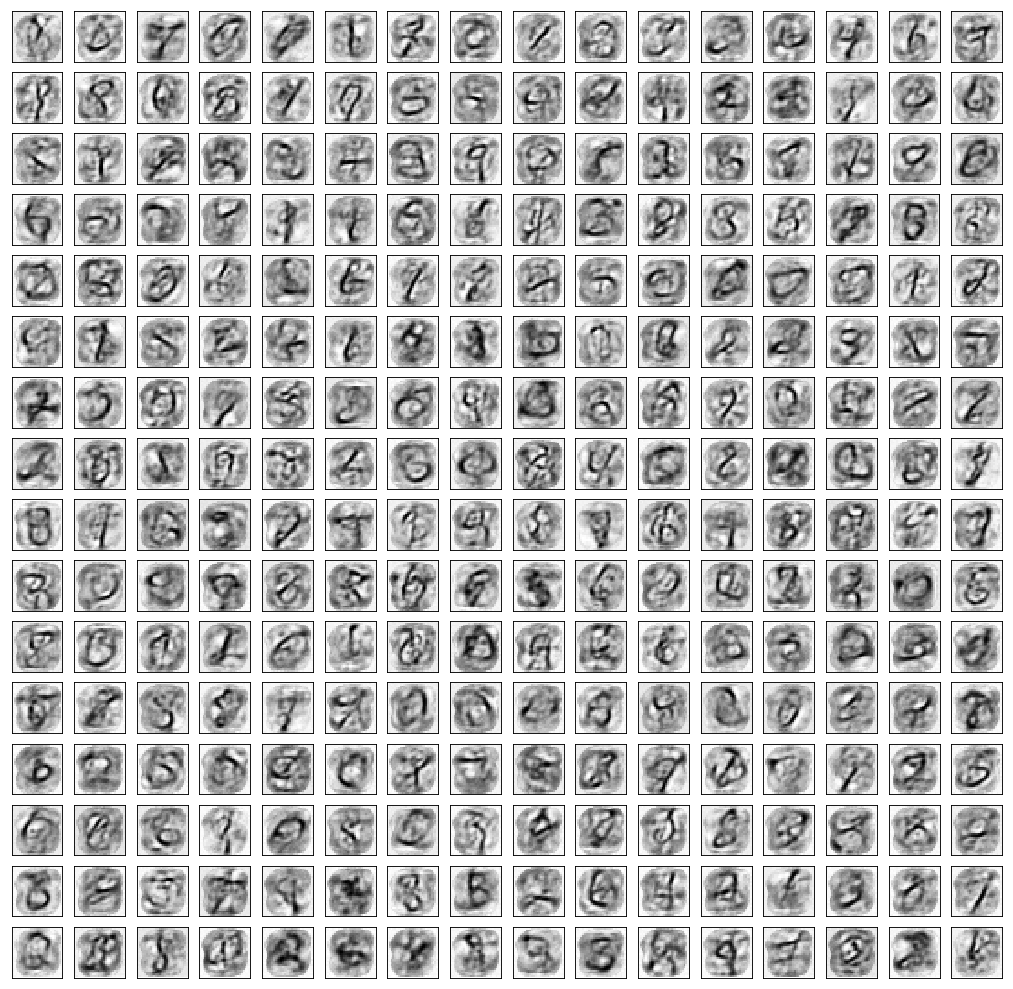

In [55]:
plot_mnist(dec_to_plot, (16, 16))

### Reconstruction of corrupted images.

Training of SAE to remove noise.

In [57]:
# Add noise. 

def noise_pixels(x):
    f = x + torch.randn_like(x)    
    return f
    
def noise_batch(batch):
    batch_z = batch.clone().detach()
    for i in range(batch_z.shape[0]):
        batch_z[i] = noise_pixels(batch_z[i])
    return batch_z

In [80]:
models = {"256": Net(256)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [81]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, add_noise=True)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log, add_noise=True)

Train Epoch: 1 [0/50000 (0%)]	Losses 256: 0.976353
Train Epoch: 1 [10000/50000 (20%)]	Losses 256: 0.358382
Train Epoch: 1 [20000/50000 (40%)]	Losses 256: 0.288163
Train Epoch: 1 [30000/50000 (60%)]	Losses 256: 0.244846
Train Epoch: 1 [40000/50000 (80%)]	Losses 256: 0.215631
Train Epoch: 1 [50000/50000 (100%)]	Losses 256: 0.192812
Test set:
256: loss: 0.1954	rho_loss: 0.0050

Train Epoch: 2 [0/50000 (0%)]	Losses 256: 0.186815
Train Epoch: 2 [10000/50000 (20%)]	Losses 256: 0.188396
Train Epoch: 2 [20000/50000 (40%)]	Losses 256: 0.179526
Train Epoch: 2 [30000/50000 (60%)]	Losses 256: 0.147949
Train Epoch: 2 [40000/50000 (80%)]	Losses 256: 0.151552
Train Epoch: 2 [50000/50000 (100%)]	Losses 256: 0.143883
Test set:
256: loss: 0.1463	rho_loss: 0.0046

Train Epoch: 3 [0/50000 (0%)]	Losses 256: 0.150303
Train Epoch: 3 [10000/50000 (20%)]	Losses 256: 0.131815
Train Epoch: 3 [20000/50000 (40%)]	Losses 256: 0.129909
Train Epoch: 3 [30000/50000 (60%)]	Losses 256: 0.123681
Train Epoch: 3 [40000/500

Train Epoch: 22 [30000/50000 (60%)]	Losses 256: 0.061939
Train Epoch: 22 [40000/50000 (80%)]	Losses 256: 0.063977
Train Epoch: 22 [50000/50000 (100%)]	Losses 256: 0.060035
Test set:
256: loss: 0.0606	rho_loss: 0.0041

Train Epoch: 23 [0/50000 (0%)]	Losses 256: 0.061851
Train Epoch: 23 [10000/50000 (20%)]	Losses 256: 0.060460
Train Epoch: 23 [20000/50000 (40%)]	Losses 256: 0.061833
Train Epoch: 23 [30000/50000 (60%)]	Losses 256: 0.059877
Train Epoch: 23 [40000/50000 (80%)]	Losses 256: 0.052827
Train Epoch: 23 [50000/50000 (100%)]	Losses 256: 0.059045
Test set:
256: loss: 0.0599	rho_loss: 0.0041

Train Epoch: 24 [0/50000 (0%)]	Losses 256: 0.056920
Train Epoch: 24 [10000/50000 (20%)]	Losses 256: 0.061769
Train Epoch: 24 [20000/50000 (40%)]	Losses 256: 0.064869
Train Epoch: 24 [30000/50000 (60%)]	Losses 256: 0.060443
Train Epoch: 24 [40000/50000 (80%)]	Losses 256: 0.062298
Train Epoch: 24 [50000/50000 (100%)]	Losses 256: 0.061634
Test set:
256: loss: 0.0593	rho_loss: 0.0041

Train Epoch: 2

Train Epoch: 43 [50000/50000 (100%)]	Losses 256: 0.053188
Test set:
256: loss: 0.0540	rho_loss: 0.0041

Train Epoch: 44 [0/50000 (0%)]	Losses 256: 0.052370
Train Epoch: 44 [10000/50000 (20%)]	Losses 256: 0.053875
Train Epoch: 44 [20000/50000 (40%)]	Losses 256: 0.049740
Train Epoch: 44 [30000/50000 (60%)]	Losses 256: 0.051911
Train Epoch: 44 [40000/50000 (80%)]	Losses 256: 0.056188
Train Epoch: 44 [50000/50000 (100%)]	Losses 256: 0.054352
Test set:
256: loss: 0.0536	rho_loss: 0.0041

Train Epoch: 45 [0/50000 (0%)]	Losses 256: 0.055336
Train Epoch: 45 [10000/50000 (20%)]	Losses 256: 0.048085
Train Epoch: 45 [20000/50000 (40%)]	Losses 256: 0.050404
Train Epoch: 45 [30000/50000 (60%)]	Losses 256: 0.048715
Train Epoch: 45 [40000/50000 (80%)]	Losses 256: 0.048617
Train Epoch: 45 [50000/50000 (100%)]	Losses 256: 0.060405
Test set:
256: loss: 0.0534	rho_loss: 0.0041

Train Epoch: 46 [0/50000 (0%)]	Losses 256: 0.051376
Train Epoch: 46 [10000/50000 (20%)]	Losses 256: 0.052284
Train Epoch: 46 [20

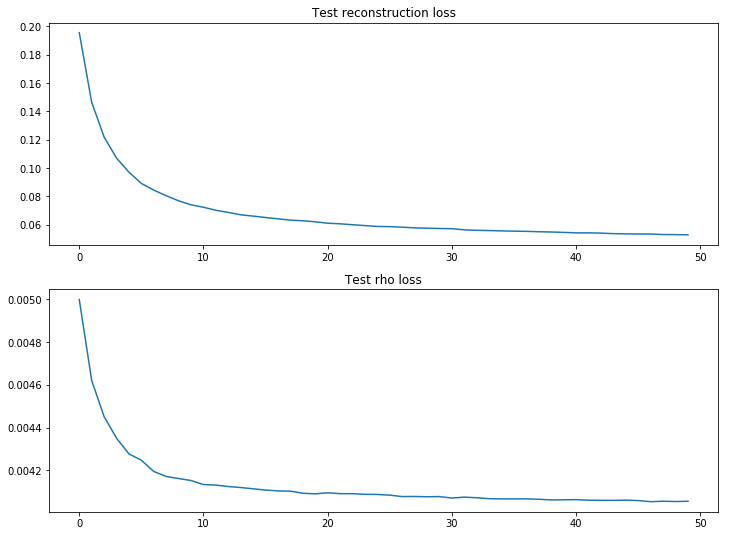

In [82]:
fig, ax = plt.subplots(2, figsize=(12,9))
ax[0].plot(np.array(test_log["256"])[:,0])
ax[0].set_title("Test reconstruction loss")
ax[1].plot(np.array(test_log["256"])[:,1])
ax[1].set_title("Test rho loss")
plt.show()

In [83]:
data, _ = next(iter(test_loader))
inputs = noise_batch(data)
output = models["256"](inputs)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

decoded = models["256"].decode(torch.eye(256))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = models["256"].E(inputs.view(-1, 28*28))    
    print("Number of neurons with activation > 0.5:\n", (encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.    
    decoded_f = models["256"].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

Number of neurons with activation > 0.5:
 tensor([ 7, 12,  5, 11, 12,  3,  9,  4,  9,  8, 13,  8,  7,  4,  3,  9,  5,  8,
        13,  2,  6,  7,  7,  5,  5,  6,  4,  7,  6,  6,  7,  3,  7, 10, 11, 11,
         3,  4,  2,  8,  3,  8,  5,  4,  2,  3,  8,  5,  9, 10])


After 50 epochs of training model did quite a good job of reconstructing heavily noised images.

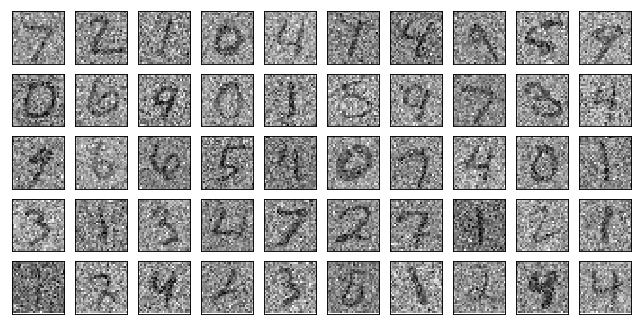

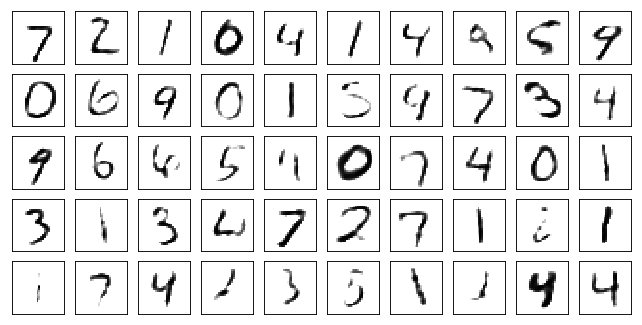

In [84]:
plot_mnist(inputs.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))

And it performed even better with deactevated neurons (<0.5 set to 0) than when it was trained on clean images.

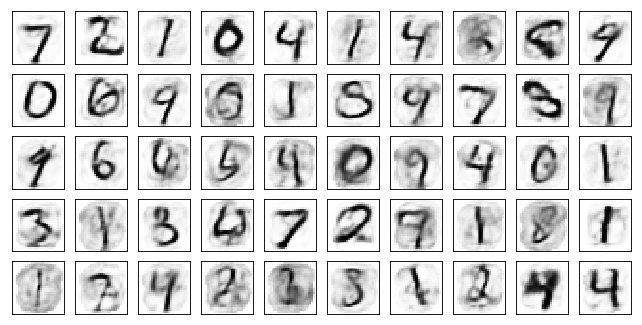

In [85]:
plot_mnist(f_to_plot, (5, 10))

Reconstructions from one active neuron also look more clear.

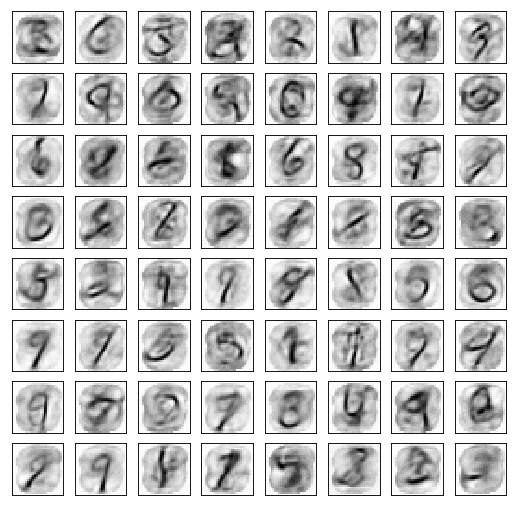

In [86]:
plot_mnist(dec_to_plot[:64], (8, 8))

Training on images cut in half.

In [87]:
# Cuts left part.

def half_pixels(x):
    f = x    
    f[0,:,:14] = 0    
    return f
    
def half_batch(batch):
    batch_z = batch.clone().detach() 
    for i in range(batch_z.shape[0]):
        batch_z[i] = half_pixels(batch_z[i])
    return batch_z

In [88]:
models = {"256": Net(256)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [92]:
for epoch in range(1, 51):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, half_image=True)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log, half_image=True)

Train Epoch: 1 [0/50000 (0%)]	Losses 256: 1.025555
Train Epoch: 1 [10000/50000 (20%)]	Losses 256: 0.348391
Train Epoch: 1 [20000/50000 (40%)]	Losses 256: 0.292280
Train Epoch: 1 [30000/50000 (60%)]	Losses 256: 0.253016
Train Epoch: 1 [40000/50000 (80%)]	Losses 256: 0.234395
Train Epoch: 1 [50000/50000 (100%)]	Losses 256: 0.230586
Test set:
256: loss: 0.2157	rho_loss: 0.0050

Train Epoch: 2 [0/50000 (0%)]	Losses 256: 0.226037
Train Epoch: 2 [10000/50000 (20%)]	Losses 256: 0.190100
Train Epoch: 2 [20000/50000 (40%)]	Losses 256: 0.197743
Train Epoch: 2 [30000/50000 (60%)]	Losses 256: 0.180966
Train Epoch: 2 [40000/50000 (80%)]	Losses 256: 0.161188
Train Epoch: 2 [50000/50000 (100%)]	Losses 256: 0.158256
Test set:
256: loss: 0.1604	rho_loss: 0.0046

Train Epoch: 3 [0/50000 (0%)]	Losses 256: 0.170744
Train Epoch: 3 [10000/50000 (20%)]	Losses 256: 0.159470
Train Epoch: 3 [20000/50000 (40%)]	Losses 256: 0.135672
Train Epoch: 3 [30000/50000 (60%)]	Losses 256: 0.152894
Train Epoch: 3 [40000/500

Train Epoch: 22 [30000/50000 (60%)]	Losses 256: 0.065732
Train Epoch: 22 [40000/50000 (80%)]	Losses 256: 0.062090
Train Epoch: 22 [50000/50000 (100%)]	Losses 256: 0.070711
Test set:
256: loss: 0.0701	rho_loss: 0.0041

Train Epoch: 23 [0/50000 (0%)]	Losses 256: 0.065371
Train Epoch: 23 [10000/50000 (20%)]	Losses 256: 0.066340
Train Epoch: 23 [20000/50000 (40%)]	Losses 256: 0.062562
Train Epoch: 23 [30000/50000 (60%)]	Losses 256: 0.069122
Train Epoch: 23 [40000/50000 (80%)]	Losses 256: 0.072766
Train Epoch: 23 [50000/50000 (100%)]	Losses 256: 0.069631
Test set:
256: loss: 0.0693	rho_loss: 0.0041

Train Epoch: 24 [0/50000 (0%)]	Losses 256: 0.064893
Train Epoch: 24 [10000/50000 (20%)]	Losses 256: 0.072222
Train Epoch: 24 [20000/50000 (40%)]	Losses 256: 0.068048
Train Epoch: 24 [30000/50000 (60%)]	Losses 256: 0.062543
Train Epoch: 24 [40000/50000 (80%)]	Losses 256: 0.064108
Train Epoch: 24 [50000/50000 (100%)]	Losses 256: 0.067617
Test set:
256: loss: 0.0688	rho_loss: 0.0041

Train Epoch: 2

Train Epoch: 43 [50000/50000 (100%)]	Losses 256: 0.061230
Test set:
256: loss: 0.0632	rho_loss: 0.0040

Train Epoch: 44 [0/50000 (0%)]	Losses 256: 0.054265
Train Epoch: 44 [10000/50000 (20%)]	Losses 256: 0.069010
Train Epoch: 44 [20000/50000 (40%)]	Losses 256: 0.061550
Train Epoch: 44 [30000/50000 (60%)]	Losses 256: 0.059890
Train Epoch: 44 [40000/50000 (80%)]	Losses 256: 0.063885
Train Epoch: 44 [50000/50000 (100%)]	Losses 256: 0.054952
Test set:
256: loss: 0.0630	rho_loss: 0.0040

Train Epoch: 45 [0/50000 (0%)]	Losses 256: 0.058240
Train Epoch: 45 [10000/50000 (20%)]	Losses 256: 0.055301
Train Epoch: 45 [20000/50000 (40%)]	Losses 256: 0.060389
Train Epoch: 45 [30000/50000 (60%)]	Losses 256: 0.064535
Train Epoch: 45 [40000/50000 (80%)]	Losses 256: 0.071090
Train Epoch: 45 [50000/50000 (100%)]	Losses 256: 0.060657
Test set:
256: loss: 0.0628	rho_loss: 0.0040

Train Epoch: 46 [0/50000 (0%)]	Losses 256: 0.066135
Train Epoch: 46 [10000/50000 (20%)]	Losses 256: 0.058558
Train Epoch: 46 [20

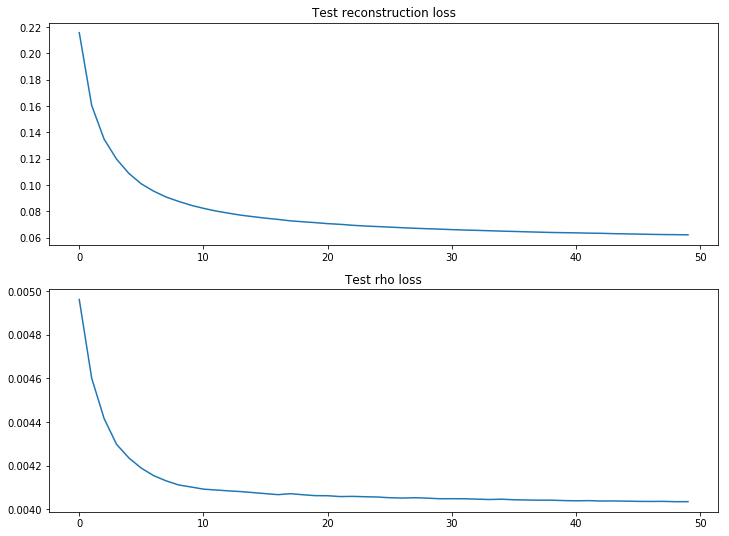

In [93]:
fig, ax = plt.subplots(2, figsize=(12,9))
ax[0].plot(np.array(test_log["256"])[:,0])
ax[0].set_title("Test reconstruction loss")
ax[1].plot(np.array(test_log["256"])[:,1])
ax[1].set_title("Test rho loss")
plt.show()

In [94]:
data, _ = next(iter(test_loader))
inputs = half_batch(data)
output = models["256"](inputs)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

decoded = models["256"].decode(torch.eye(256))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = models["256"].E(inputs.view(-1, 28*28))    
    print("Number of neurons with activation > 0.5:\n", (encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.    
    decoded_f = models["256"].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

Number of neurons with activation > 0.5:
 tensor([ 4,  6,  4,  4,  5,  5,  5,  4,  6,  6,  6,  4,  6,  6,  4,  6,  3,  8,
         6,  2,  5,  4,  4,  5,  2,  7,  6,  4,  4,  9,  3,  7,  5,  5,  6, 10,
         3,  6,  5,  2,  6,  3,  1,  6,  5,  1,  7,  1, 10,  5])


Plot of reconstructed half images from test set.

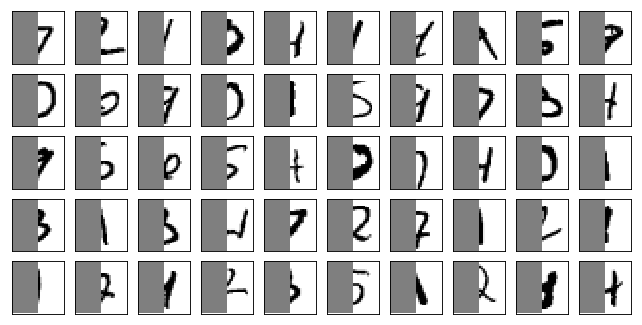

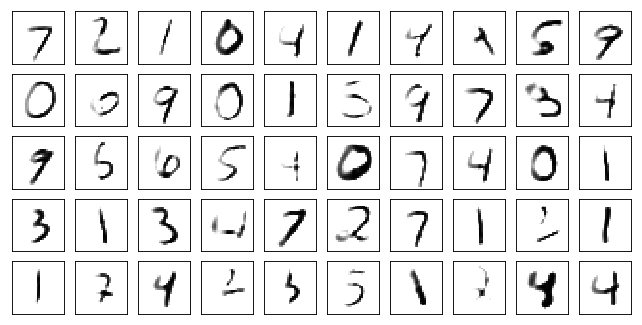

In [95]:
plot_mnist(inputs.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))

Again, looks like making task more difficult for SAE forces it to extract better features (than training on original images).

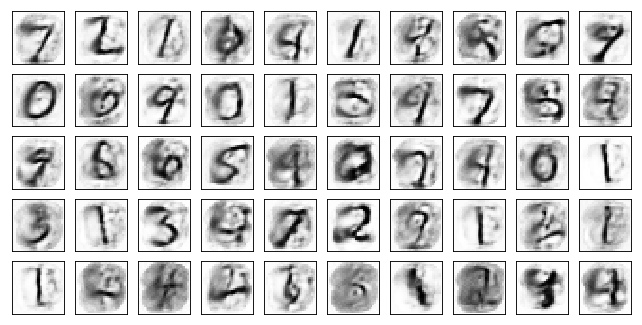

In [96]:
plot_mnist(f_to_plot, (5, 10))

Although, reconstructions from identity matrix look worse in case of halved images.

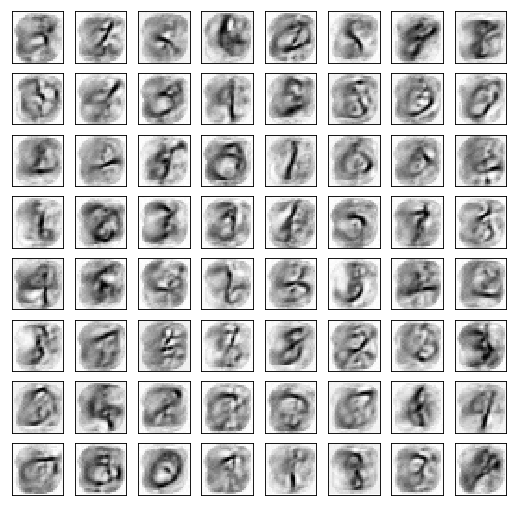

In [97]:
plot_mnist(dec_to_plot[:64], (8, 8))